Intro to TensorFlow Probability
=========================

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf                            # importing Tensorflow
import tensorflow_probability as tfp               # Tensorflow probability
from tensorflow_probability import edward2 as ed   # Edwardlib extension
#tf.enable_eager_execution()

tfd = tfp.distributions             # Basic probability distribution toolkit

plt.style.use('fivethirtyeight')        # Styling plots like FiveThirtyEight
rc = {'xtick.labelsize': 40, 'ytick.labelsize': 40, 'axes.labelsize': 40, 'font.size': 40, 'lines.linewidth': 4.0, 
      'lines.markersize': 40, 'savefig.dpi': 200,
      'text.usetex': False, 'legend.fontsize': 40.0, 'axes.titlesize': 40, "figure.figsize": [24, 16]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina' # improves resolution of plots
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## TensorFlow Probability (TFP)

### Session( ) Context
In TFP, all the variables in a model are handled within a Tensorflow session object.

In [2]:
with tf.Session() as sess1:
    normal_rv = ed.Normal(name="normal", loc=0., scale=1.)

## Edward2

In [3]:
normal_rv = ed.Normal(name="normal_rv", loc=0., scale=1.)
x = normal_rv.distribution.sample(sample_shape=1)

In [4]:
x

<tf.Tensor 'normal_rv/sample_1/Reshape:0' shape=(1,) dtype=float32>

In [5]:
print(x)

Tensor("normal_rv/sample_1/Reshape:0", shape=(1,), dtype=float32)


In [6]:
logp = normal_rv.distribution.log_prob(1.231)

In [7]:
print(logp)

Tensor("normal_rv/log_prob/sub:0", shape=(), dtype=float32)


In [8]:
dirichlet_rv = ed.Dirichlet(name="dirichlet_rv", concentration=tf.zeros([2, 5]))

In [9]:
dir__ = dirichlet_rv.distribution.sample(sample_shape=1)
dir__

<tf.Tensor 'dirichlet_rv/sample_1/Reshape:0' shape=(1, 2, 5) dtype=float32>

In [10]:
print(dir__)

Tensor("dirichlet_rv/sample_1/Reshape:0", shape=(1, 2, 5), dtype=float32)


In [14]:
with tf.Session() as sess2:
    [dir_, logp_, normal_] = sess2.run([dir__, logp, normal_rv])
dir_, logp_, normal_    

(array([[[0.2, 0.2, 0.2, 0.2, 0.2],
         [0.2, 0.2, 0.2, 0.2, 0.2]]], dtype=float32), -1.6766189, -2.369414)

In [15]:
x = ed.Normal(name="x", loc=tf.zeros(2), scale=tf.ones(2)).distribution.sample(sample_shape=2)
x

<tf.Tensor 'x/sample_1/Reshape:0' shape=(2, 2) dtype=float32>

In [ ]:
with tf.Session() as sess3:
    x_values = sess3.run(x)
    
x_values    

Random variables can interoperate with TensorFlow operations(ops): the TF ops operate on the sample

In [13]:
y = 10.
z = x + y
z

<tf.Tensor 'add:0' shape=(2, 2) dtype=float32>

In [14]:
with tf.Session() as sess4:
    z_values = sess4.run(z)
    
z_values    

array([[ 8.123221, 10.941624],
       [ 8.278514, 10.867475]], dtype=float32)

## Example I

Probabilistic models in Edward2 are expressed as Python functions. Inputs to the function are the variables conditioned on.

### Prepare the data

In [3]:
num_of_variables = 10
sample_size = 100
input_data = tf.random_normal(shape=[sample_size, num_of_variables])
output_data = tf.random_uniform(shape=[sample_size], minval=0, maxval=2, dtype=tf.int32)

In [4]:
with tf.Session() as sess5:
    data = sess5.run([output_data, input_data]) 

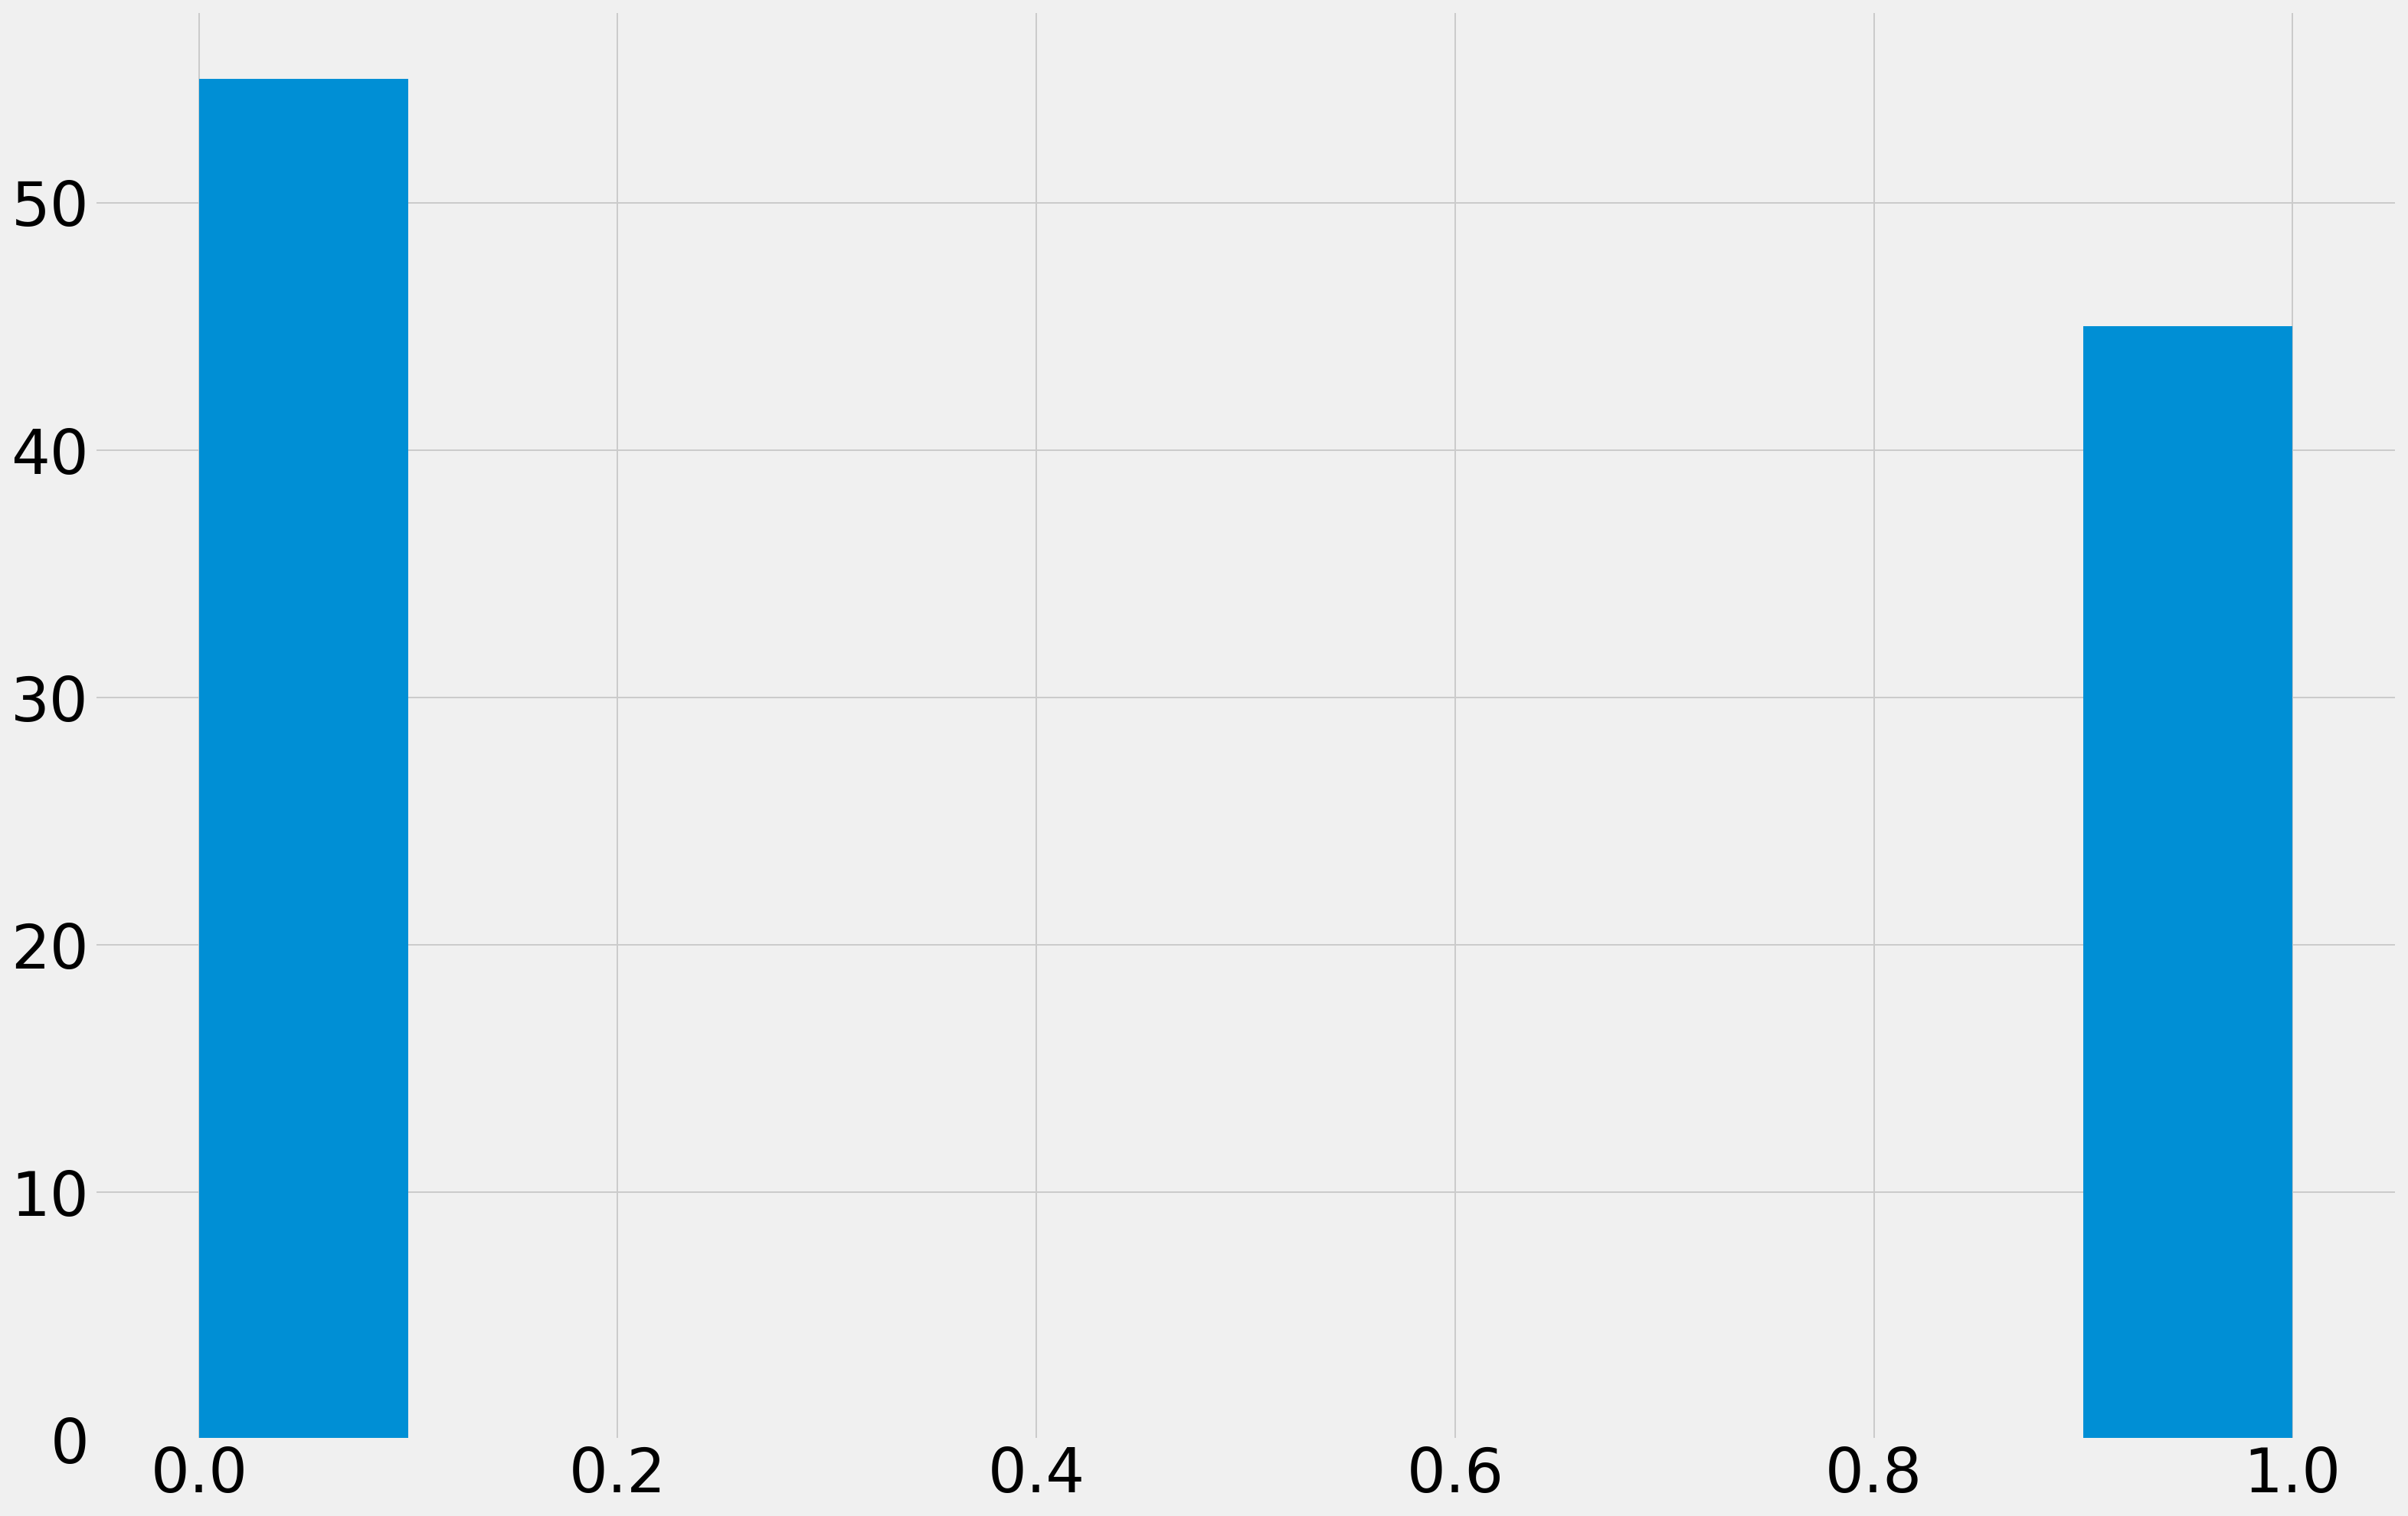

In [5]:
plt.hist(data[0]);

### Build the model

Probabilistic models in Edward2 are expressed as Python functions. Inputs to the function are the variables conditioned on.

In [4]:
def logistic_regression_model(X):
    
    # Priors
    coefficients = ed.Normal(name="coefficients", loc=tf.zeros(X.shape[1]), scale=1.)
    intercept = ed.Normal(name="intercept", loc=0., scale=1.)
    
    mean = tf.tensordot(a=X, b=coefficients, axes=[[1], [0]]) + intercept
    
    # likelihood
    observations = ed.Bernoulli(name="observations", logits=mean)
    return coefficients, intercept, observations

In [7]:
# Simulate data from the model
with tf.Session() as sess_logit_model:
    obs_logit_ = logistic_regression_model(X=input_data)
    obs_logit = sess_logit_model.run(obs_logit_)

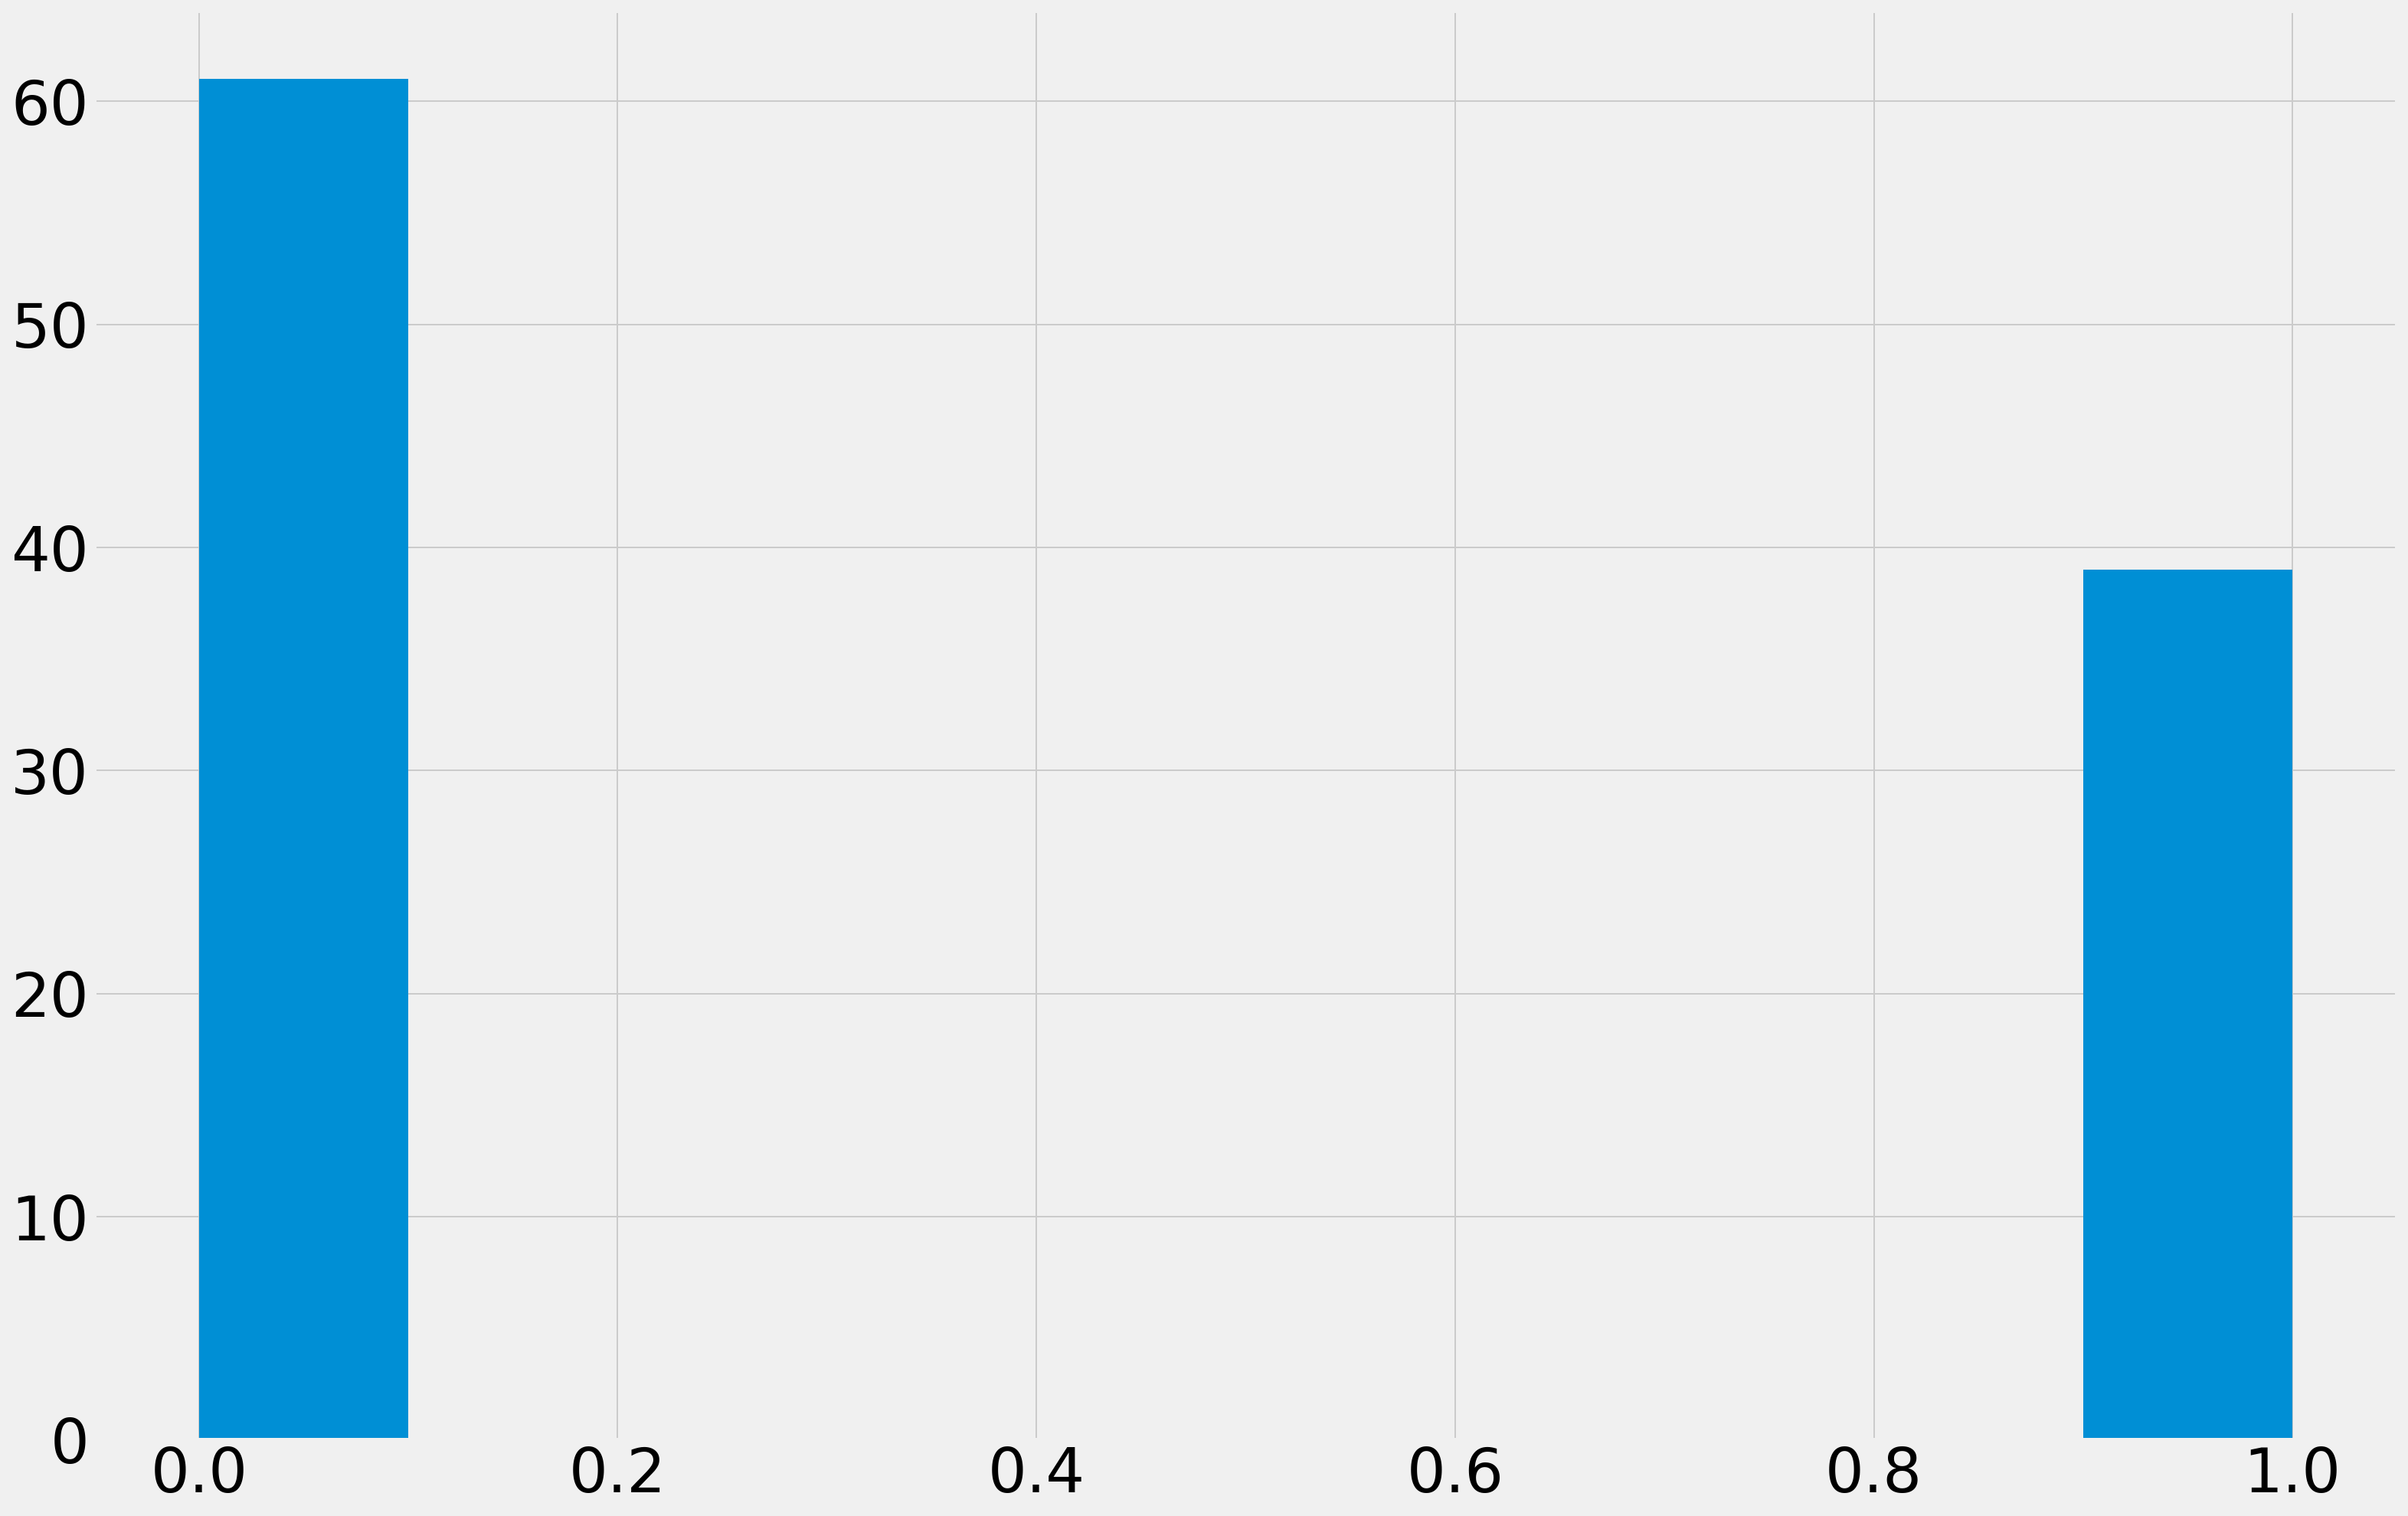

In [8]:
plt.hist(obs_logit[2]);

### Perform Inference

In [5]:
# Define the target log-probability function
def target_log_prob_fn(coefficients, intercept):
    log_joint = ed.make_log_joint_fn(logistic_regression_model)
    return log_joint(X=input_data, 
                     coefficients=coefficients, 
                     intercept=intercept, 
                     observations=output_data)

In [6]:
# Pass the target log-probability function to MCMC transition kernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn, 
    step_size=0.1, 
    num_leapfrog_steps=5)

In [7]:
posterior_, kernel_results_ = tfp.mcmc.sample_chain(
    num_results=2000, 
    kernel=hmc_kernel, 
    current_state=[tf.random_normal([num_of_variables]), tf.random_normal([])]
)

In [8]:
with tf.Session() as sess6:
    posterior, kernel_results = sess6.run([posterior_, kernel_results_])

In [57]:
posterior

[array([[ 1.23454499e+00, -5.29537320e-01,  2.56325305e-01, ...,
         -5.61078906e-01,  6.10797286e-01, -1.50004995e+00],
        [ 4.63765681e-01,  5.17678320e-01, -5.51589370e-01, ...,
         -2.96718717e-01,  1.41228110e-01, -1.08574182e-01],
        [ 7.00128555e-01, -5.37776947e-01,  1.44457191e-01, ...,
          6.88411295e-02,  5.44470429e-01, -7.28535056e-01],
        ...,
        [ 2.81039625e-01, -1.36443317e-01, -1.36505626e-03, ...,
         -1.89894766e-01, -2.54852414e-01, -1.03717774e-01],
        [ 9.05339718e-01, -2.81044468e-02, -7.84435943e-02, ...,
         -4.51861620e-01,  4.72477138e-01, -7.13243723e-01],
        [-4.13052067e-02,  2.90339589e-01,  4.63036597e-02, ...,
         -2.18547493e-01,  2.86587536e-01, -1.64738595e-01]], dtype=float32),
 array([-0.22570577, -0.49601158,  0.06852669, ..., -0.507801  ,
         0.10641573, -0.40068737], dtype=float32)]

In [74]:
posterior[0].mean(axis=0)

array([ 0.4139317 ,  0.01990473, -0.05365106,  0.18452388,  0.3909374 ,
       -0.14250118, -0.19428632, -0.2559822 ,  0.1253763 , -0.32384425],
      dtype=float32)

In [76]:
kernel_results

UncalibratedHamiltonianMonteCarloKernelResults(log_acceptance_correction=array([-35.551746  ,  -9.712345  ,   3.1811004 , ...,   0.12862158,
         1.5010004 ,  -3.5543437 ], dtype=float32), target_log_prob=array([-102.16594,  -92.0848 ,  -95.38084, ...,  -83.56519,  -85.05496,
        -81.36513], dtype=float32), grads_target_log_prob=[array([[ -7.6073856 ,  10.197836  , -11.527021  , ...,   4.9047294 ,
         -7.2556667 ,  15.839924  ],
       [  2.021736  ,  -9.721662  ,   9.841384  , ...,  -2.7480364 ,
          2.6762094 ,  -6.533907  ],
       [ -4.080062  ,  11.305866  ,  -8.743612  , ...,  -3.6899385 ,
         -7.5970535 ,   7.883093  ],
       ...,
       [  4.6179557 ,   2.646771  ,  -2.0373013 , ...,  -0.37372175,
          8.617219  ,  -1.397815  ],
       [ -6.804408  ,   1.6840062 ,   1.4771062 , ...,   0.43582302,
         -5.90917   ,   3.2831848 ],
       [ 10.569896  ,  -5.973592  ,  -2.975623  , ...,   1.4728948 ,
         -1.8152068 ,  -0.5249643 ]], dtype=float

### Diagnoze convergence

In [ ]:
import arviz as az
# import pandas as pd

In [62]:
import pandas as pd
posterior_df = pd.DataFrame(data=posterior[1])
posterior_df.head()

,0
0,-0.225706
1,-0.496012
2,0.068527
3,-0.172776
4,-0.283585


In [61]:
import xarray as xr

In [63]:
posterior_xr = xr.DataArray(data=posterior_df)

In [65]:
posterior_xr

<xarray.DataArray (dim_0: 2000, dim_1: 1)>
array([[-0.225706],
       [-0.496012],
       [ 0.068527],
       ...,
       [-0.507801],
       [ 0.106416],
       [-0.400687]], dtype=float32)
Coordinates:
  * dim_0    (dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * dim_1    (dim_1) int64 0

In [ ]:
az.traceplot(posterior_xr)

### Critize the model

### Use the model for prediction

## Example II

### Prepare the data

In [3]:
def build_toy_dataset(N, w, noise_std=0.1):
  D = len(w)
  x = np.random.randn(N, D)
  y = np.dot(x, w) + np.random.normal(0, noise_std, size=N)
  return x.astype("float32"), y.astype("float32")

N = 40  # number of data points
D = 10  # number of features

w_true = np.random.randn(D)
X_train, y_train = build_toy_dataset(N, w_true)
X_test, y_test = build_toy_dataset(N, w_true)

In [4]:
X_train.shape

(40, 10)

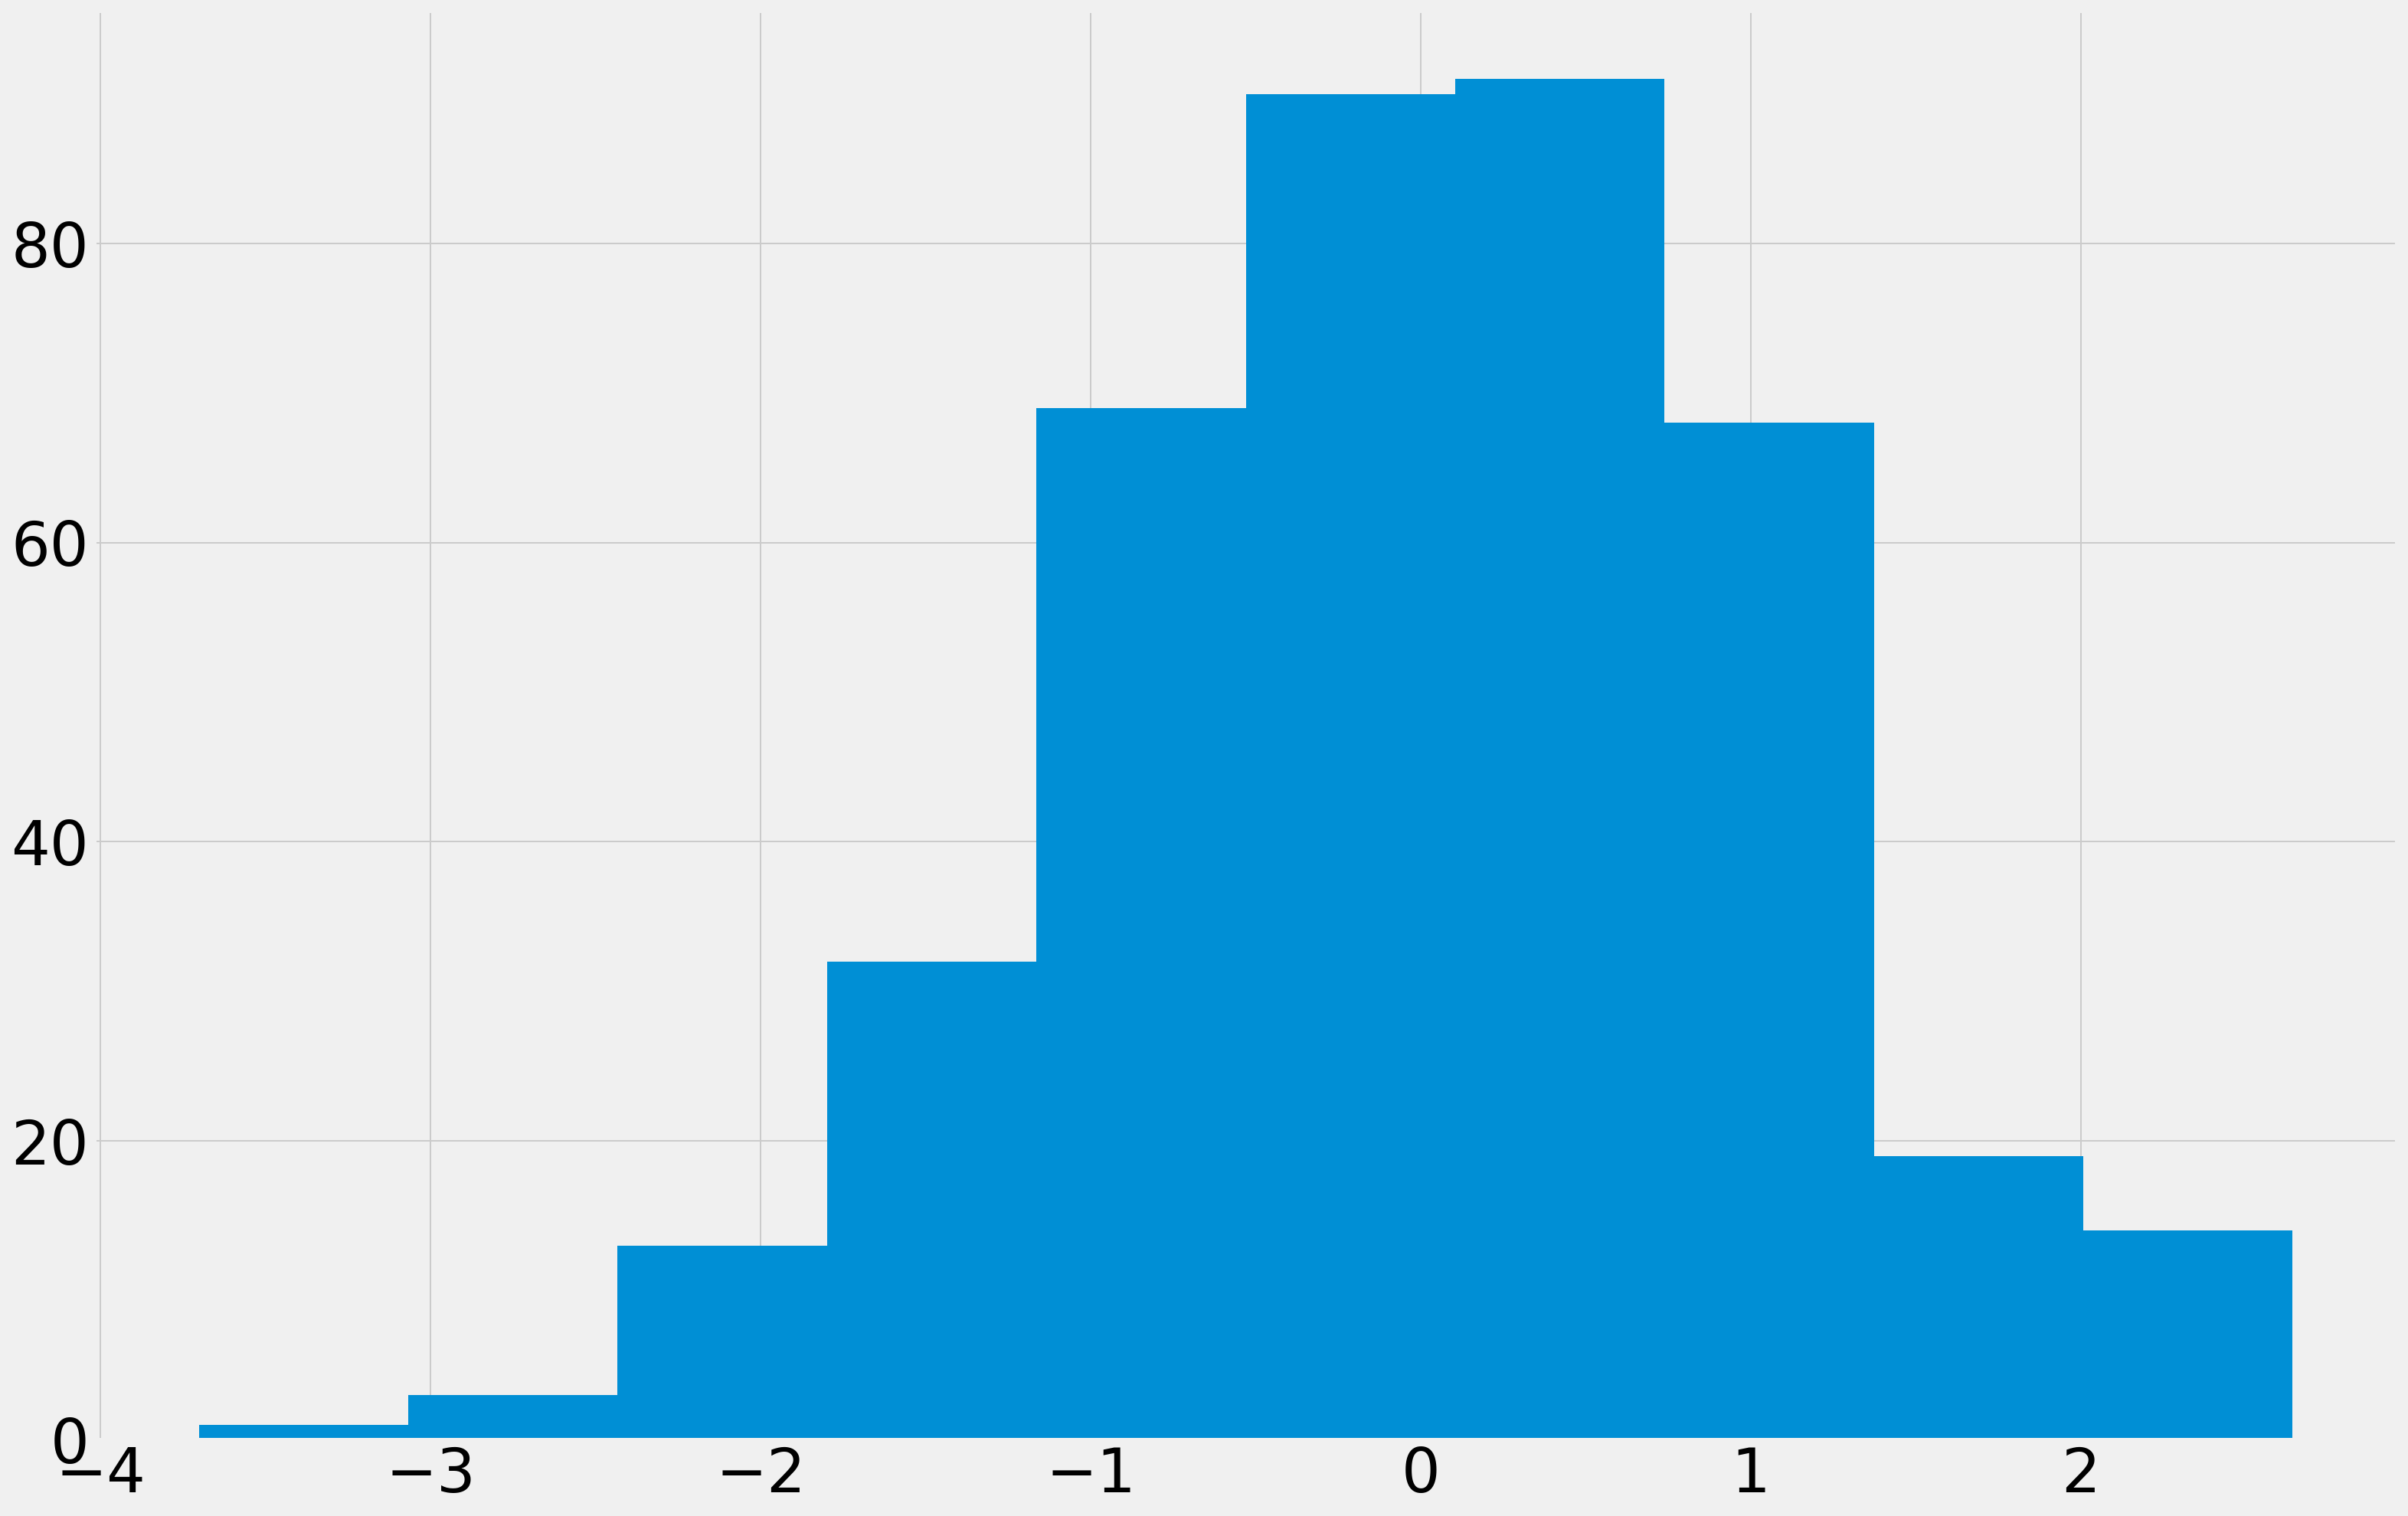

In [5]:
plt.hist(X_train.flatten());

### Build the model

In [33]:
def linear_regression_model(X):
    # Priors
    noise = ed.HalfNormal(name="noise", scale=1.0)
    coefficient = ed.Normal(name="coefficient", loc=tf.zeros(shape=X.shape[1]), scale=1.0)
    intercept = ed.Normal(name="intercept", loc=0.0, scale=1.0)
    
    # Deterministic mean
    mean = tf.tensordot(a=X, b=coefficient, axes=[[1], [0]]) + intercept
    
    # Likelihood
    observations = ed.Normal(name="observations", loc=mean, scale=noise)
    
    return observations

In [34]:
# Simulate data from the model
with tf.Session() as sess_lm:
    obs = linear_regression_model(X_train)
    y_obs = sess_lm.run(obs)

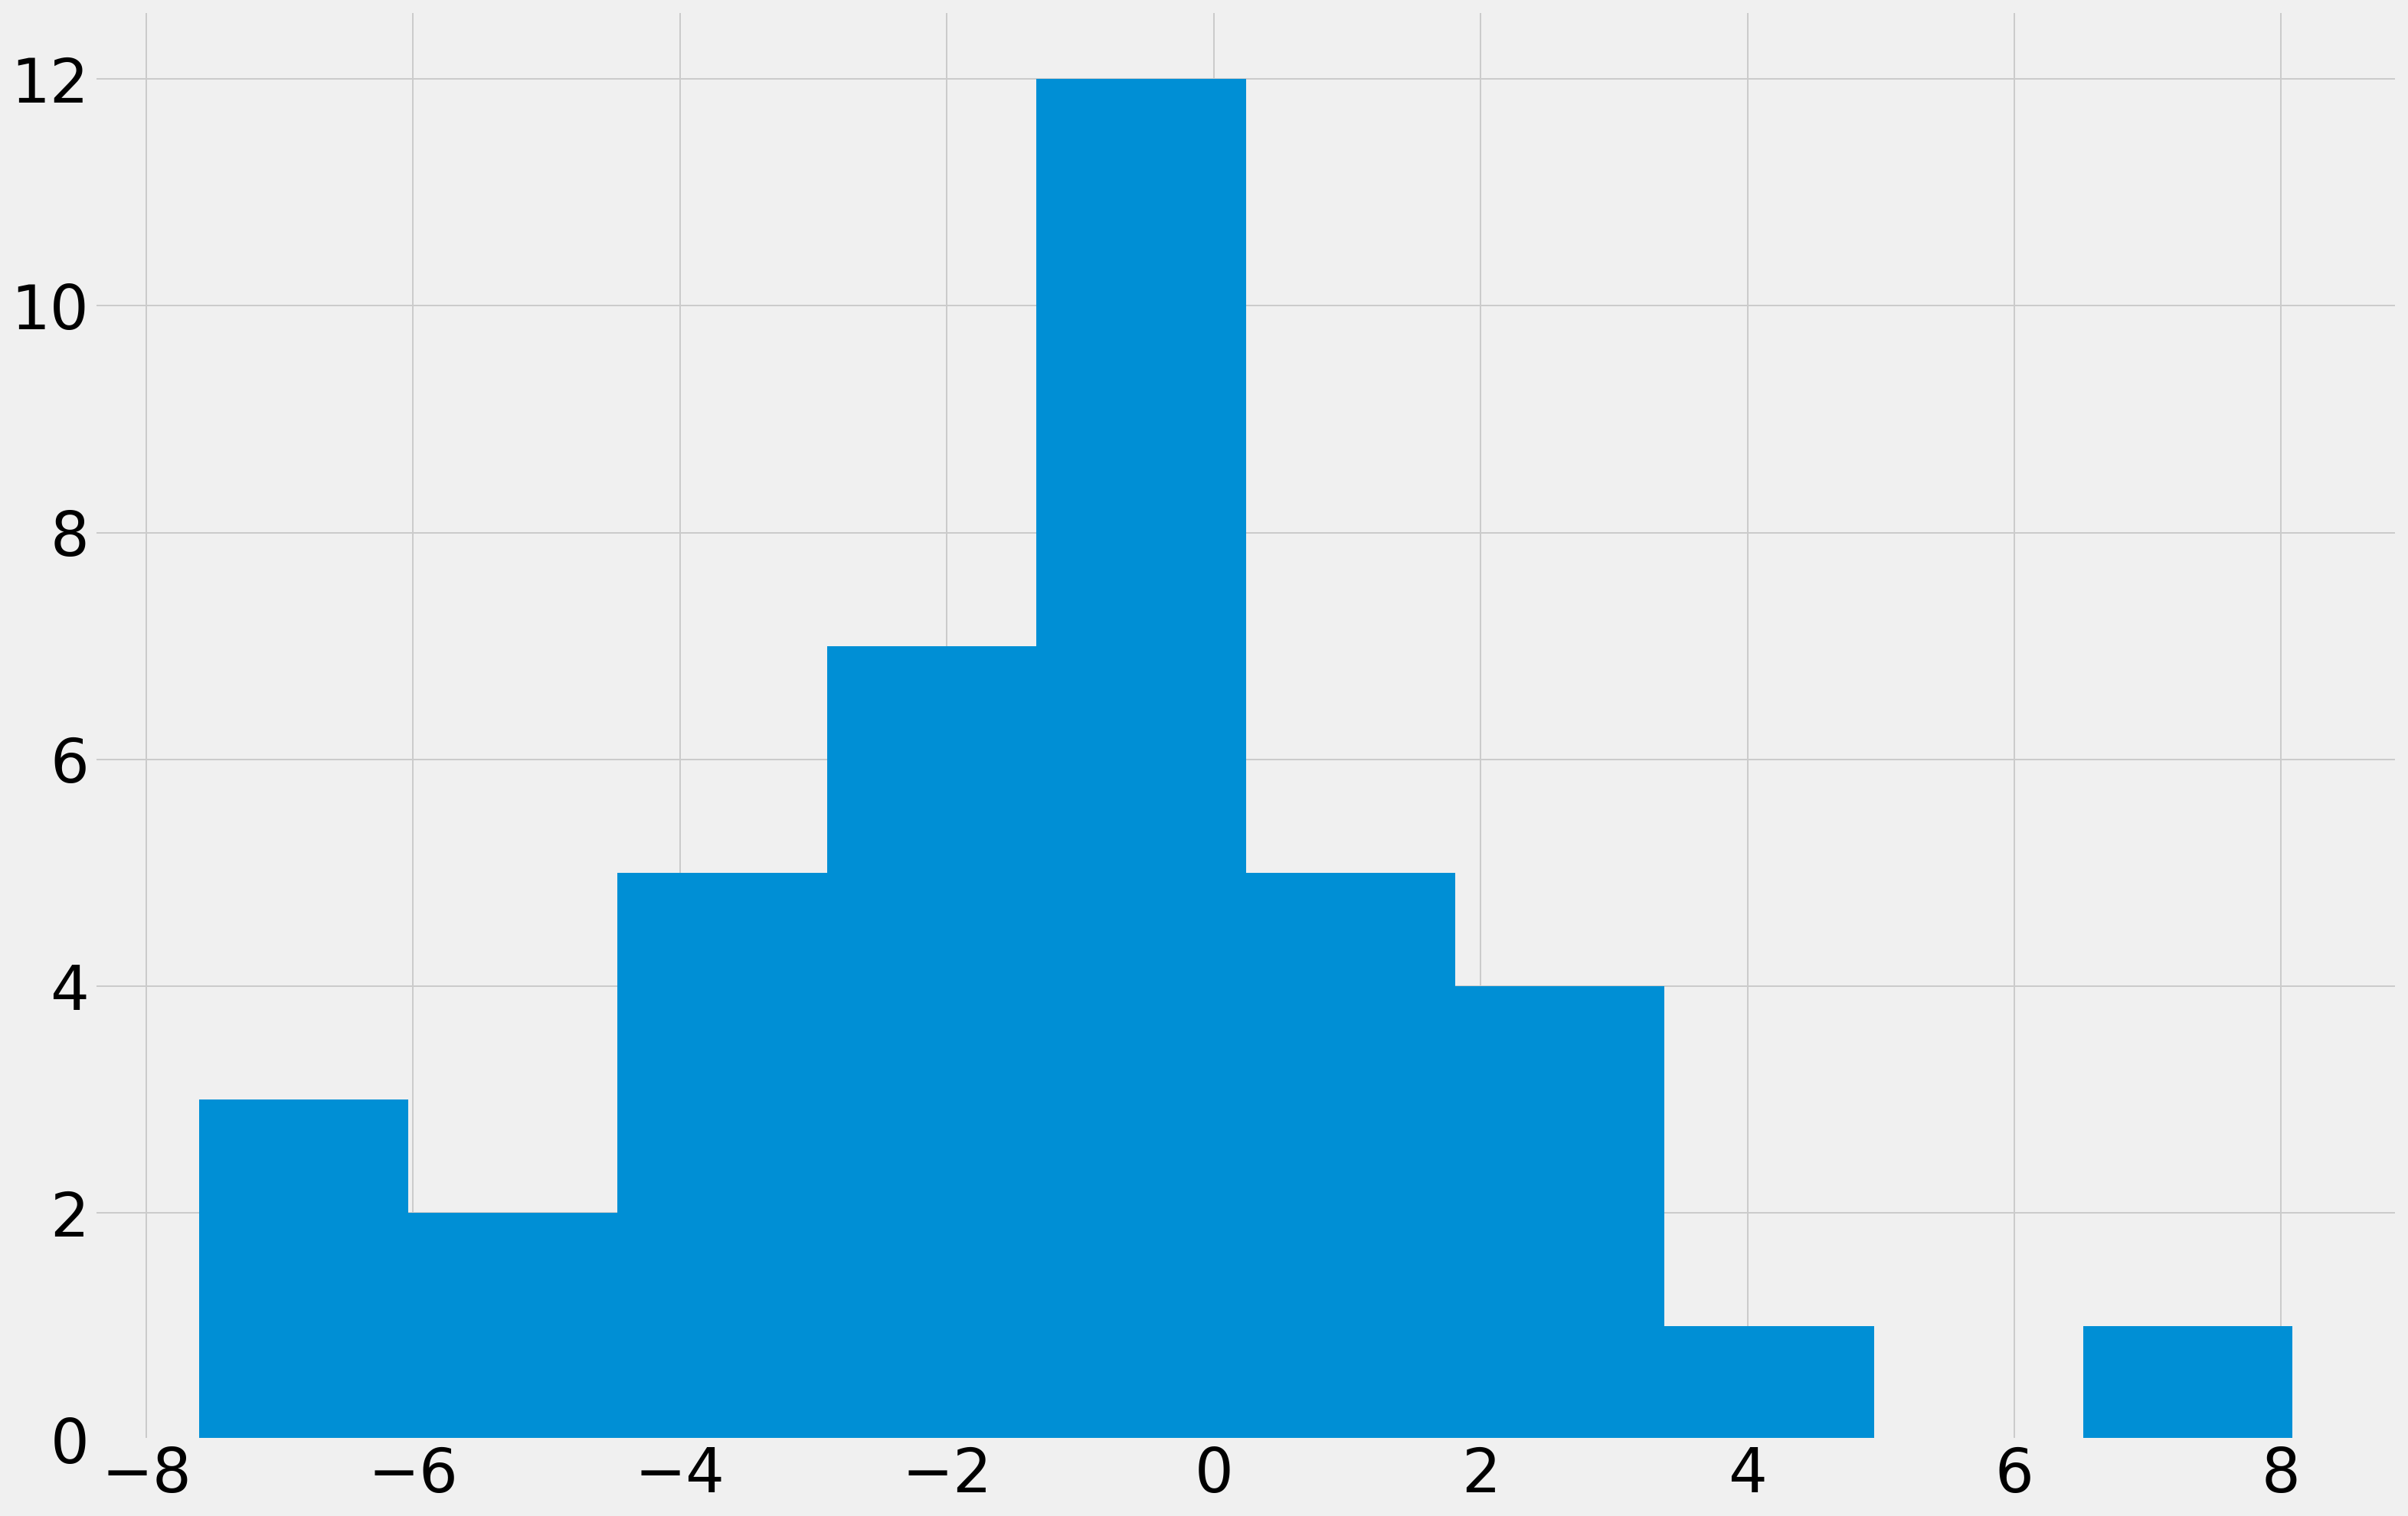

In [37]:
plt.hist(y_obs);

### Perform Inference

In [38]:
# Define the target log-probability function
log_joint = ed.make_log_joint_fn(linear_regression_model)

def target_log_prob_fn_lm(coefficient, intercept, noise):

    return log_joint(X=X_train, 
                     coefficient=coefficient, 
                     intercept=intercept,
                     noise=noise,
                     observations=y_train)

In [39]:
# Pass the target log-probability function to MCMC transition kernel
hmc_kernel_lm = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn_lm, 
    step_size=0.1, 
    num_leapfrog_steps=5)

In [53]:
num_results = int(10e4)
num_burnin_steps = int(1e3)

# Set the chain's start state.
initial_chain_state = [
    tf.zeros([X_train.shape[1]], dtype=tf.float32, name="init_coefficient"),
    tf.zeros([], dtype=tf.float32, name="init_intercept"),
    tf.ones([], dtype=tf.float32, name="init_noise"),
]


[
posterior_coefficient, 
posterior_intercept, 
posterior_sigma
], kernel_results_lm = tfp.mcmc.sample_chain(num_results=num_results, 
                                              num_burnin_steps=num_burnin_steps,
                                              kernel=hmc_kernel_lm,
                                              current_state=initial_chain_state)

In [56]:
with tf.Session() as sess_lm_model:
    [
        posterior_coefficient_, 
        posterior_intercept_, 
        posterior_sigma_,
        kernel_results_lm_
    ] = sess_lm_model.run([
        posterior_coefficient, 
        posterior_intercept, 
        posterior_sigma,
        kernel_results_lm        
    ])

In [80]:
trace_coefficient = posterior_coefficient_
trace_intercept = posterior_intercept_
trace_sigma = posterior_sigma_

In [81]:
trace_sigma.flatten().shape

(100000,)

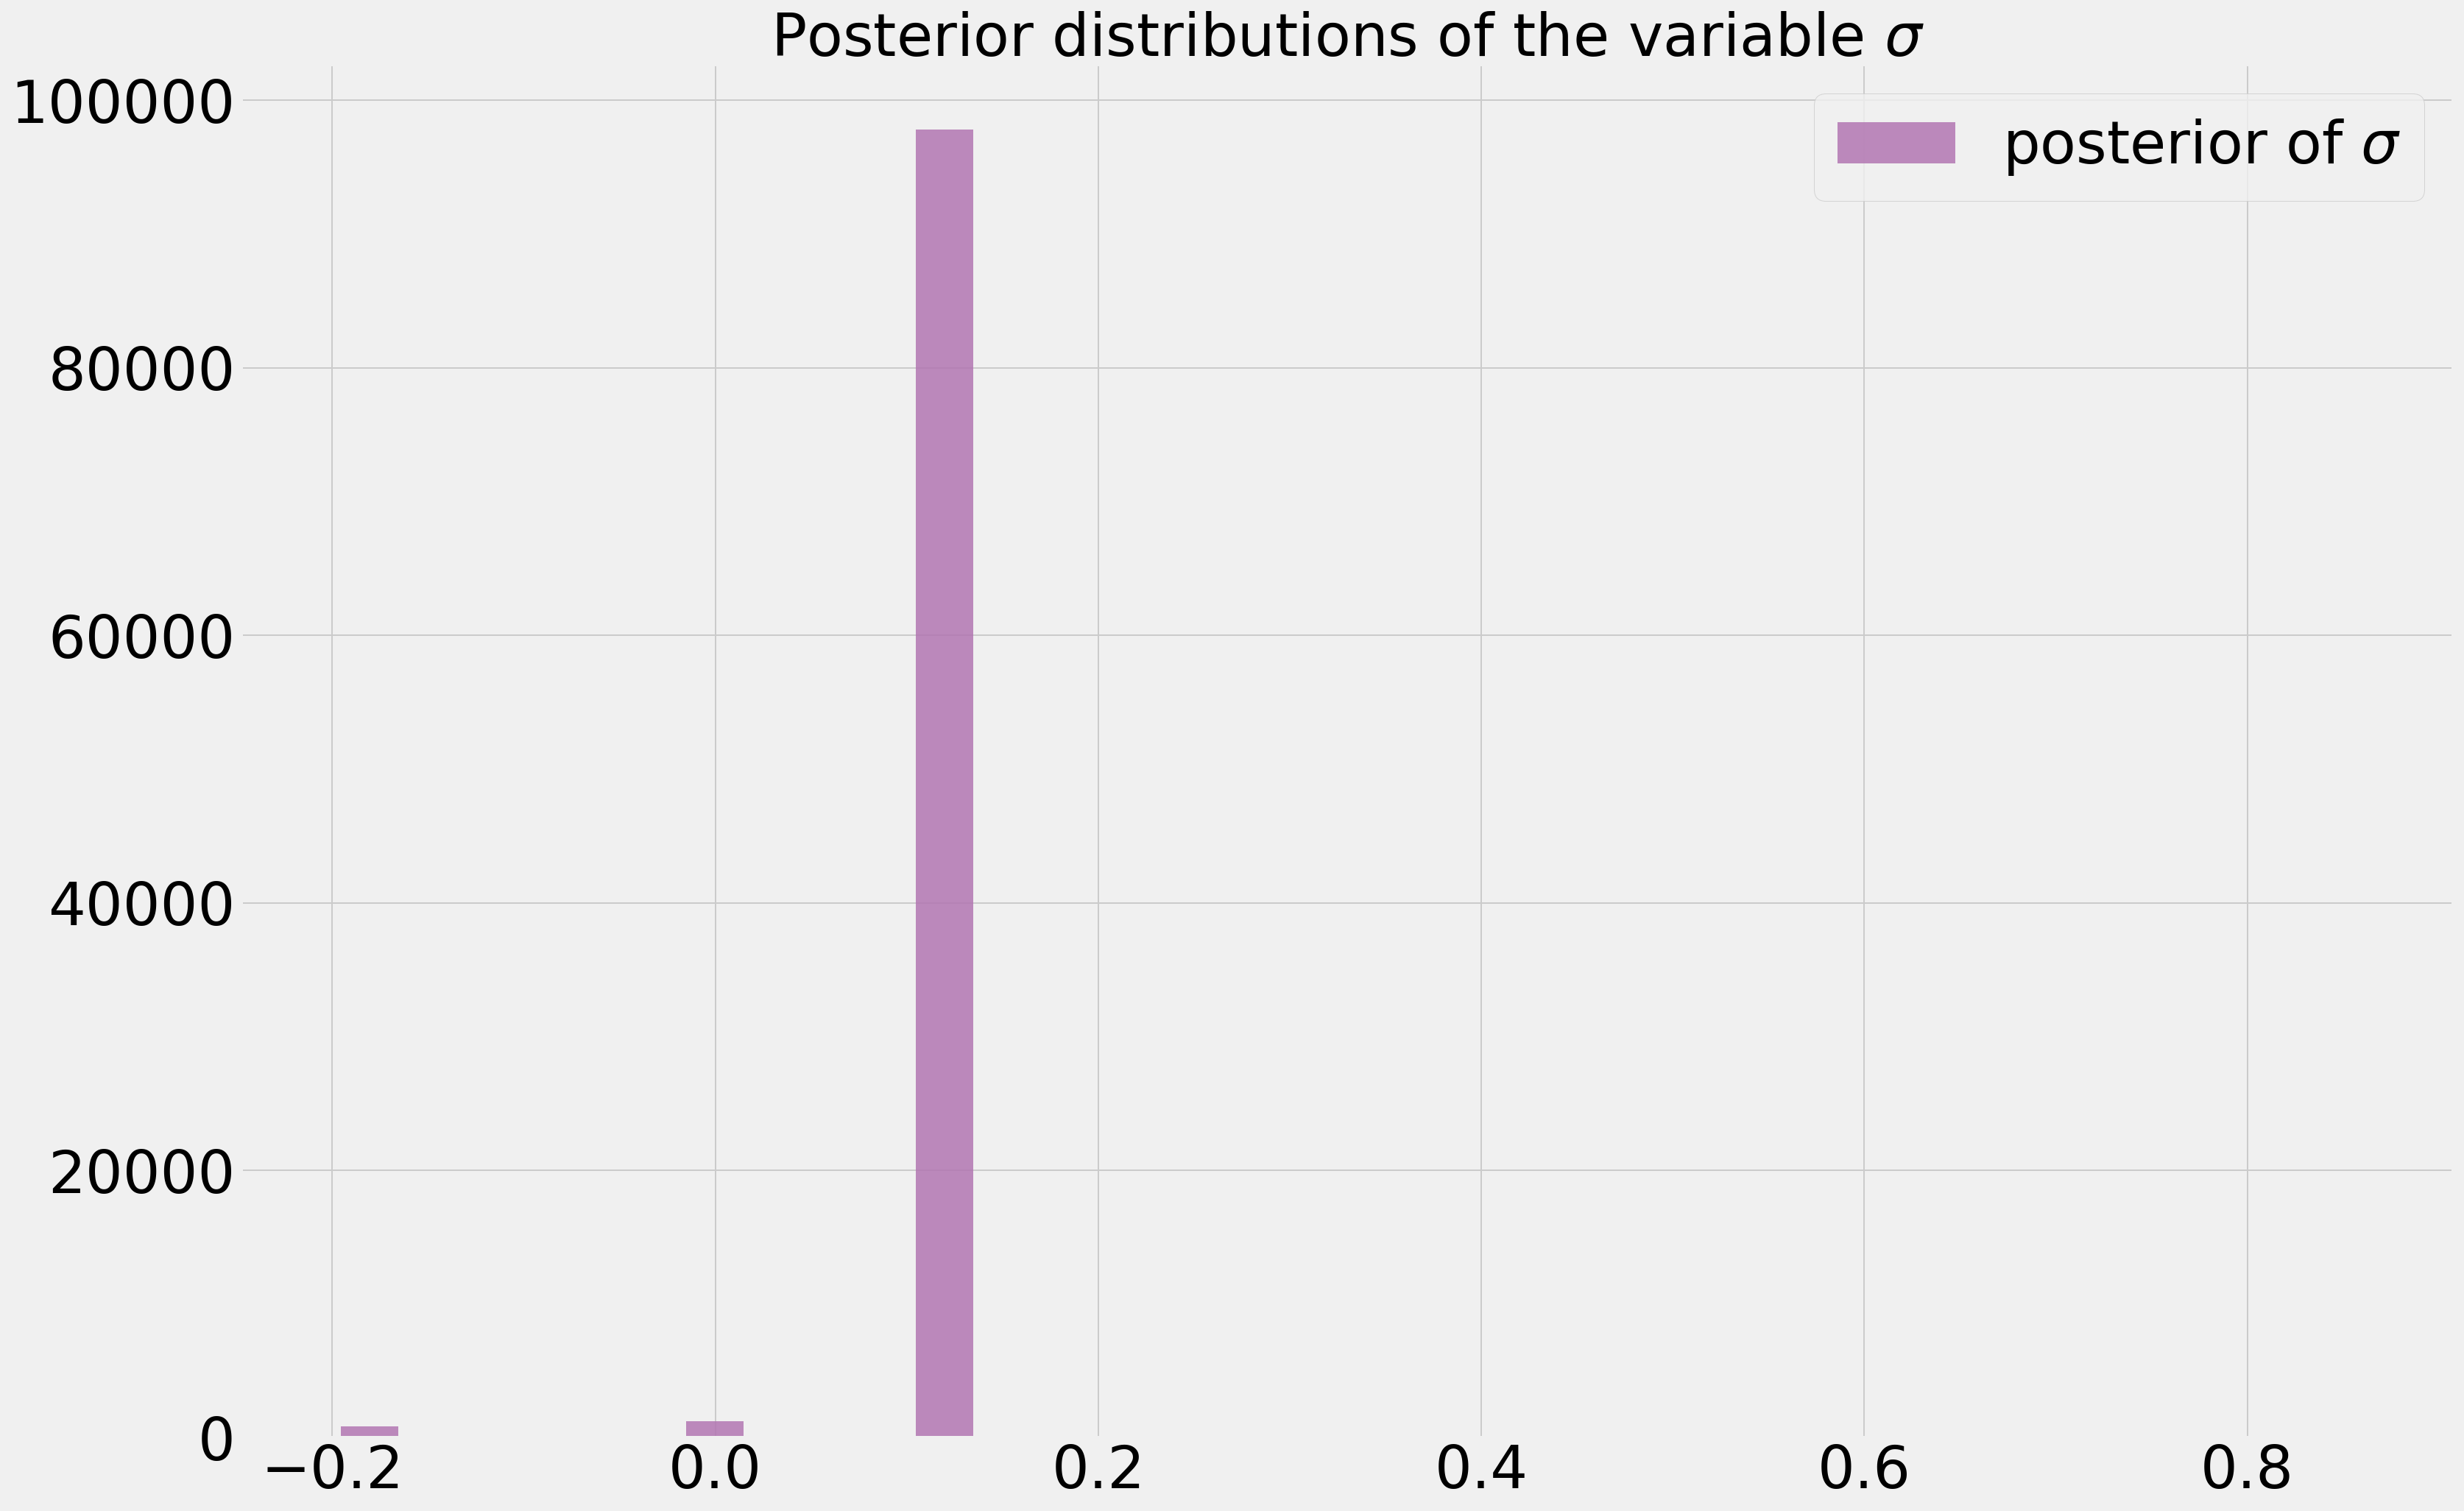

In [84]:
plt.title(r"Posterior distributions of the variable $\sigma$")
plt.hist(trace_intercept.flatten(), bins=35,  alpha=0.85,
         label=r"posterior of $\sigma$", color="#B276B2")
plt.legend();